In [1]:
# ライブラリのimport

# NumPy用ライブラリ
import numpy as np

# Matplotlib中のpyplotライブラリのインポート
import matplotlib.pyplot as plt

# matplotlib日本語化対応ライブラリのインポート
import japanize_matplotlib

# pandas用ライブラリ
import pandas as pd

# データフレーム表示用関数
from IPython.display import display

# seaborn
import seaborn as sns

# 表示オプション調整
# NumPy表示形式の設定
np.set_printoptions(precision=3, floatmode="fixed")
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14
# サイズ設定
plt.rcParams["figure.figsize"] = (6, 6)
# 方眼表示ON
plt.rcParams["axes.grid"] = True
# データフレームでの表示精度
pd.options.display.float_format = "{:.3f}".format
# データフレームですべての項目を表示
pd.set_option("display.max_columns", None)

In [2]:
import pymc as pm
import arviz as az

print(f"Running on PyMC v{pm.__version__}")
print(f"Running on ArViz v{az.__version__}")

Running on PyMC v5.25.1
Running on ArViz v0.22.0


In [3]:
# アイリスデータセットの読み込み
# ------------------------------------------------------------
# seaborn に内蔵されている "iris" データセットを読み込む。
# このデータセットは、3 種類のアヤメ（setosa, versicolor, virginica）の
# がく(sepal)と花弁(petal)の長さ・幅を特徴量として持ち、
#
#   - 教師あり学習（多クラス分類）の代表的なトイデータ
#   - 線形分離性やクラス間の重なりを直感的に確認できる教材
#
# として広く用いられる。
df = sns.load_dataset("iris")

# 代表サンプルの抽出
# ------------------------------------------------------------
# df.iloc[[0, 1, 50, 51, 100, 101]] は
#   - インデックス 0, 1  : setosa の最初の 2 サンプル
#   - インデックス 50, 51: versicolor の最初の 2 サンプル
#   - インデックス 100,101: virginica の最初の 2 サンプル
# を行単位で取り出している。
#
# つまり、3 クラス * 各 2 サンプルずつ = 6 行からなる
# 「ごく少数の代表点」を抜き出しているイメージである。
#
# 理論的には、こうした少数サンプルを抜き出しておくことで
#   - 各クラスの特徴量の典型的なスケール感
#   - クラス間での値の違い（例：setosa は sepal_length が短い など）
# を、人間が表形式でざっと確認しやすくなる。
# 後続の可視化やベイズモデル構築の前に「データの中身を把握する」
# という探索的データ解析 (EDA) の第一歩と位置づけられる。
df1 = df.iloc[[0, 1, 50, 51, 100, 101]]

# 抽出したサンプルの表示
# ------------------------------------------------------------
# display(df1) によって、Notebook 上に 6 行分の特徴量とラベルを表示する。
# ここで、
#   - sepal_length, sepal_width, petal_length, petal_width
#     の値の違い
#   - species 列（クラスラベル）の変化
# を目視することで、
# 「どの特徴量がクラス識別に効きそうか」を直感的に把握する狙いがある。
display(df1)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.100,3.500,1.400,0.200,setosa
1,4.900,3.000,1.400,0.200,setosa
50,7.000,3.200,4.700,1.400,versicolor
51,6.400,3.200,4.500,1.500,versicolor
100,6.300,3.300,6.000,2.500,virginica
101,5.800,2.700,5.100,1.900,virginica


In [4]:
# アイリスデータセットの読み込み
# ------------------------------------------------------------
# seaborn に組み込みの "iris" データセットを読み込む。
# iris データは、3 種類のアヤメ（setosa, versicolor, virginica）に対して
#
#   - sepal_length（がく片の長さ）
#   - sepal_width （がく片の幅）
#   - petal_length（花弁の長さ）
#   - petal_width （花弁の幅）
#
# の4つの実数値特徴量と、クラスラベル species を持つ。
# 教師あり学習（多クラス分類）の入門データセットとして標準的に使われる。
df = sns.load_dataset("iris")

# 先頭5件の確認
# ------------------------------------------------------------
# head() で最初の 5 行だけを表示し、データフレームの構造をざっと把握する。
# これは探索的データ解析 (EDA) の最初のステップで、
#   - 各列の名前と型（float / category など）
#   - 値のスケール感（例: sepal_length は 4〜8 程度）
#   - 欠損値の有無
# を目視で確認することが目的。
display(df.head())

# species の分布確認
# ------------------------------------------------------------
# df['species'].value_counts() は、クラスラベル（setosa / versicolor / virginica）が
# それぞれ何件ずつ含まれているかをカウントする。
#
# 理論的には、
#   - クラス分布がほぼ一様（ほぼ同数）なら「クラス不均衡」の問題は小さい
#   - 片方のクラスが極端に少ない場合は、分類器の学習や評価指標に注意が必要
# といった判断につながる。
#
# iris データセットでは、通常は各クラス 50 サンプルずつで完全にバランスしている。
# それを value_counts() で確認することで、
# 「クラスバランスが良い＝精度だけでなく再現率なども比較的素直に解釈しやすい」
# という前提を持ったうえで、後続のモデリング（線形判別分析やベイズ分類器など）に
# 進むことができる。
df["species"].value_counts()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.100,3.500,1.400,0.200,setosa
1,4.900,3.000,1.400,0.200,setosa
2,4.700,3.200,1.300,0.200,setosa
3,4.600,3.100,1.500,0.200,setosa
4,5.000,3.600,1.400,0.200,setosa


species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

([<matplotlib.axis.XTick at 0x13ace3f40>,
 [Text(4.0, 0, '4.0'),
  Text(4.2, 0, '4.2'),
  Text(4.4, 0, '4.4'),
  Text(4.6000000000000005, 0, '4.6'),
  Text(4.800000000000001, 0, '4.8'),
  Text(5.000000000000001, 0, '5.0'),
  Text(5.200000000000001, 0, '5.2'),
  Text(5.400000000000001, 0, '5.4'),
  Text(5.600000000000001, 0, '5.6'),
  Text(5.800000000000002, 0, '5.8'),
  Text(6.000000000000002, 0, '6.0')])

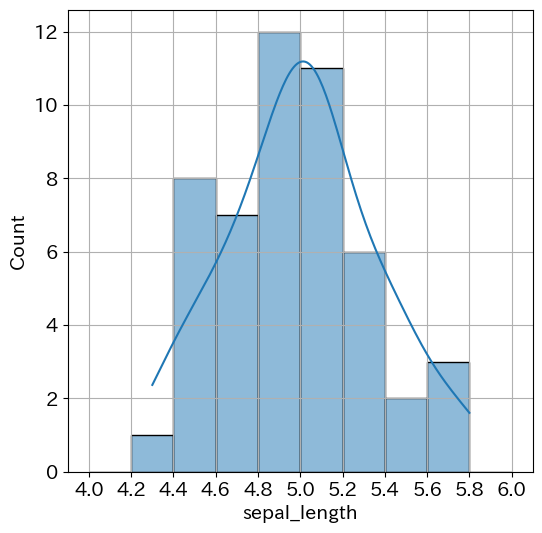

In [5]:
# setosa の行のみ抽出
# ------------------------------------------------------------
# iris データセットには 3 クラス（setosa, versicolor, virginica）のサンプルが
# 含まれているが、ここではそのうち setosa クラスだけに注目する。
#
#   df.query('species == "setosa"')
#
# は、ブール条件
#   species == "setosa"
# を満たす行だけを抽出する操作であり、
#
#   { (sepal_length_i, sepal_width_i, ..., species_i = setosa) }_{i=1}^{n_setosa}
#
# という「条件付きデータ分布」
#
#   p(x | species = setosa)
#
# を取り出している、と解釈できる。
# その後、この部分集合に対して特徴量 sepal_length の一変量分布を解析する。
df1 = df.query('species == "setosa"')

# ヒストグラムのビン境界の定義
# ------------------------------------------------------------
# bins = np.arange(4.0, 6.2, 0.2) は
#   4.0, 4.2, 4.4, ..., 6.0
# といった 0.2 刻みの区間境界を生成する。
#
# これはヒストグラムで sepal_length の値域 [4.0, 6.0] 付近を
# 約 0.2 幅ごとのビンに分割して、経験分布（標本分布）を近似するための設定である。
#
# 理論的には、このヒストグラムは setosa に対する
#   sepal_length | species = setosa
# の経験的な確率密度関数を「区分的に一定な関数」として近似している、と見なせる。
bins = np.arange(4.0, 6.2, 0.2)

# ヒストグラムを描画
# ------------------------------------------------------------
# sns.histplot は、指定したデータ列のヒストグラムと（オプションで）KDE を描画する。
#
#   - data: df1（setosa に限定されたサンプル集合）
#   - x='sepal_length': 横軸に sepal_length をとる
#   - bins=bins: 上で定義したビン境界で区間を切る
#   - kde=True: カーネル密度推定 (Kernel Density Estimation) による
#               連続的な密度曲線も併せて描画する
#
# KDE は、標本 {x_i} から滑らかな密度推定
#
#   \hat{f}(x) = (1 / (n h)) \sum_i K((x - x_i)/h)
#
# を構成する方法であり、ヒストグラムよりも連続的な分布形状を
# 観察するのに適している。
#
# setosa クラスの sepal_length が「ほぼ単峰で、（ほぼ）正規分布に近いかどうか」を
# ここで確認しておくことは、後の
#   - ガウス判別分析
#   - ベイズ分類器（クラス条件付きに正規分布を仮定するモデル）
# などを使う際の前提妥当性チェックとして重要になる。
sns.histplot(df1, x="sepal_length", bins=bins, kde=True)

# x 軸目盛の設定
# ------------------------------------------------------------
# plt.xticks(bins) により、x 軸の目盛位置をヒストグラムのビン境界と揃える。
# これにより、
#   「どの区間にどれくらいデータが入っているか」
# を数値的に読み取りやすくなり、例えば
#   - 中心付近（平均付近）にどれくらいの質量が集中しているか
#   - 下側／上側の裾の厚さはどの程度か
# などを視覚的に評価しやすくなる。
plt.xticks(bins)

In [6]:
# sepal_length 列の抽出
# ------------------------------------------------------------
# df1 は species == "setosa" の行だけを抜き出したデータフレーム。
# ここで
#   s1 = df1['sepal_length']
# とすることで、setosa クラスに限定した「がく片の長さ sepal_length」の
# 1 変量サンプル
#
#   { x_i }_{i=1}^{n_setosa}
#
# を取り出していると解釈できる。
# 理論的には、この {x_i} は母集団
#
#   X | species = setosa
#
# からの独立同分布サンプル（i.i.d.）である、という前提を置くことが多い。
s1 = df1["sepal_length"]

# NumPy 配列への変換
# ------------------------------------------------------------
# pandas.Series である s1 を .values で NumPy の 1 次元配列に変換する。
# 後続で
#   - 線形代数的な処理
#   - NumPy / SciPy の統計関数への入力
#   - ベイズモデル用の生データ配列として渡す
# などの用途に使うため、「純粋な数値配列 X」として取り出している。
#
# 理論的には、X は
#
#   X = (x_1, x_2, ..., x_n)^T
#
# というサンプルベクトルであり、標本平均や標本分散などの統計量を
# 数式どおりに計算する際の「ベクトル表現」に対応する。
X = s1.values

# 統計情報の確認
# ------------------------------------------------------------
# s1.describe() は、pandas が提供する要約統計量で、具体的には
#
#   count: サンプル数 n
#   mean : 標本平均
#   std  : 標本標準偏差
#   min  : 最小値
#   25%  : 第1四分位数 (Q1)
#   50%  : 第2四分位数 (中央値)
#   75%  : 第3四分位数 (Q3)
#   max  : 最大値
#
# を返す。
#
# 統計的には、
#   - mean, std は「正規分布近似」が妥当かどうかを見る手がかり
#   - quartiles（四分位点）は分布の歪みや外れ値の有無の判断
# に使われる。
# setosa の sepal_length が「ほぼ左右対称で外れ値が少ない」などの情報は、
# 後のガウス仮定（クラス条件付き分布を N(μ, σ^2) とみなす）を置く際の根拠になる。
print(s1.describe())

# 値の確認
# ------------------------------------------------------------
# X をそのまま print することで、個々の観測値 {x_i} を直接確認している。
# これは、
#   - データ入力ミス（異常に大きい／小さい値）
#   - 少数点位置のずれ
#   - 離れた外れ値
# などを目視で検出するための、もっとも原始的だが効果的なチェック手段。
#
# 理論的には、外れ値の存在は
#   - 正規分布仮定の破れ
#   - ロバストな推定量（中央値・MAD など）の必要性
#   - ベイズモデル側で「重い裾を持つ分布（例: t 分布）」を選ぶべきか
# といったモデリング判断に直結するため、この段階のチェックは重要である。
print(X)

count   50.000
mean     5.006
std      0.352
min      4.300
25%      4.800
50%      5.000
75%      5.200
max      5.800
Name: sepal_length, dtype: float64
[5.100 4.900 4.700 4.600 5.000 5.400 4.600 5.000 4.400 4.900 5.400 4.800
 4.800 4.300 5.800 5.700 5.400 5.100 5.700 5.100 5.400 5.100 4.600 5.100
 4.800 5.000 5.000 5.200 5.200 4.700 4.800 5.400 5.200 5.500 4.900 5.000
 5.500 4.900 4.400 5.100 5.000 4.500 4.400 5.000 5.100 4.800 5.100 4.600
 5.300 5.000]


In [7]:
# PyMC のモデルコンテナを生成
# ------------------------------------------------------------
# pm.Model() は「確率モデル全体」をまとめて保持するコンテナ。
# この中にパラメータの事前分布（mu, sigma）と、観測データ X に対する尤度を定義する。
model1 = pm.Model()

with model1:
    # 事前分布：平均 mu の事前は広い正規分布 N(0, 10^2)
    # --------------------------------------------------------
    # - 観測データ X を「正規分布に従う」とみなすとき、その平均 mu を未知パラメータとする。
    # - mu ~ Normal(0, 10) という指定は、
    #     「平均は 0 付近だと大まかに信じているが、不確実性は大きく、
    #      -20〜20 程度の範囲ならかなりあり得る」
    #   という“弱情報的な事前分布”になっている。
    # - ベイズ的には、この事前と尤度 p(X | mu, sigma) を組み合わせて
    #   mu の事後分布 p(mu | X, sigma) を求めることになる。
    mu = pm.Normal("mu", mu=0.0, sigma=10.0)

    # 事前分布：標準偏差 sigma の事前は半正規分布 HalfNormal(10)
    # --------------------------------------------------------
    # - 観測データのばらつき（分散／標準偏差）も未知とみなし、sigma をパラメータにする。
    # - sigma ~ HalfNormal(10) は、
    #     「0 以上で、0 付近の小さい値がやや出やすいが、
    #      10 程度までの大きさも許容する」
    #   といった形状をもつ事前分布になる（正規分布 N(0,10^2) を 0 で折り返したもの）。
    # - 分散に対して直接事前を置く代わりに、標準偏差に半正規事前を置くのは、
    #   直感的なスケール指定がしやすく、数値的にも扱いやすいという理由がある。
    sigma = pm.HalfNormal("sigma", sigma=10.0)

    # 尤度：観測データ X は N(mu, sigma^2) に従うと仮定
    # --------------------------------------------------------
    # - X_obs は観測済みデータ X に対する「尤度項」を表す。
    # - 条件付き分布として
    #     X | mu, sigma ~ Normal(mu, sigma)
    #   を仮定しており、ベイズの立場では
    #     p(X | mu, sigma)（尤度） × p(mu, sigma)（事前）
    #   から p(mu, sigma | X)（事後）を導く。
    # - observed=X とすることで、PyMC に
    #     「この正規分布モデルで X というデータが観測された」
    #   という情報を与え、MCMC による mu, sigma の事後サンプリングが可能になる。
    X_obs = pm.Normal("X_obs", mu=mu, sigma=sigma, observed=X)

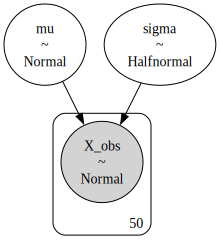

In [8]:
g = pm.model_to_graphviz(model1)
display(g)

In [9]:
with model1:
    idata1 = pm.sample(random_seed=42)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


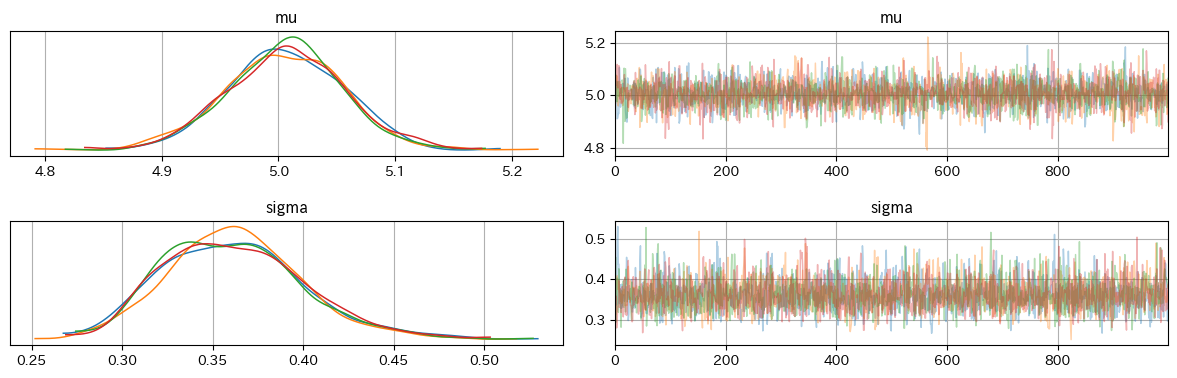

In [10]:
az.plot_trace(idata1, compact=False)
plt.tight_layout()

In [11]:
idata1

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

array([<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'sigma'}>],
      dtype=object)

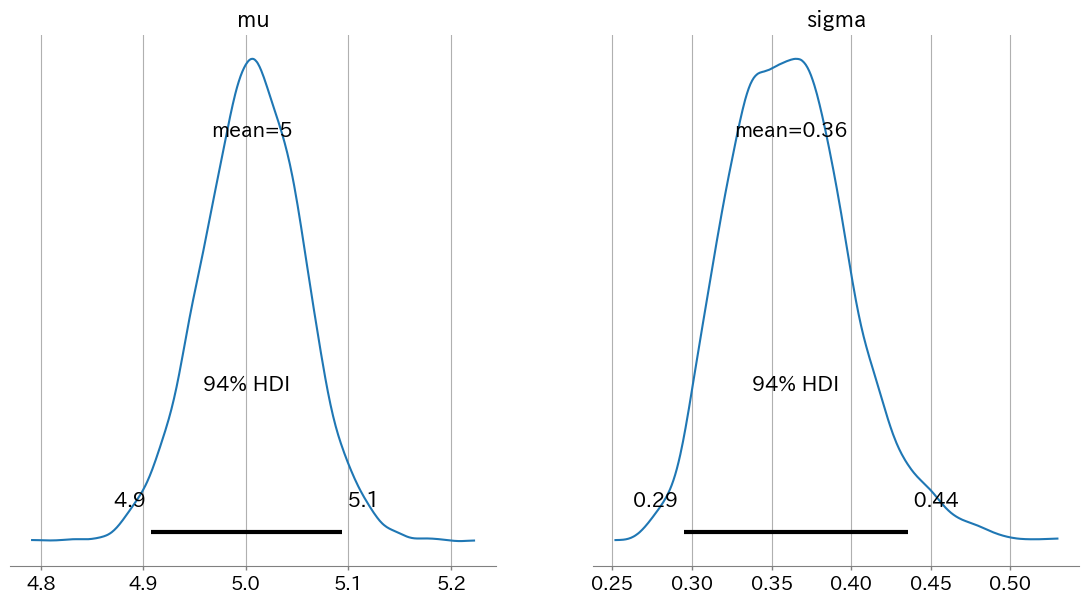

In [12]:
az.plot_posterior(idata1)

In [13]:
summary1 = az.summary(idata1)
display(summary1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,5.006,0.050,4.908,5.094,0.001,0.001,3718.000,2711.000,1.000
sigma,0.362,0.039,0.295,0.436,0.001,0.001,3437.000,2488.000,1.000


In [14]:
mu_mean1 = summary1.loc["mu", "mean"]
sigma_mean1 = summary1.loc["sigma", "mean"]

# 結果確認
print(f"mu={mu_mean1}, sigma={sigma_mean1}")

mu=5.006, sigma=0.362


In [15]:
def norm(x, mu, sigma):
    # 正規分布の確率密度関数（PDF）を実装する関数
    # ------------------------------------------------------------
    # 連続型確率変数 X が
    #
    #   X ~ N(mu, sigma^2)
    #
    # に従うとき、その確率密度関数は
    #
    #   f(x | mu, sigma)
    #     = 1 / (sqrt(2π) * sigma) * exp( - (x - mu)^2 / (2 * sigma^2) )
    #
    # で与えられる。
    # 以下では、この式を「標準化」と「係数」に分解して実装している。
    # ------------------------------------------------------------

    # y は標準化された変数
    #   y = (x - mu) / sigma
    # であり、「元の正規分布 N(mu, sigma^2) を標準正規分布 N(0,1) に写像する変換」
    # に対応する。理論的には、積分変数の変換 x -> y によって
    #   N(mu, sigma^2) の積分が N(0,1) の積分に帰着することを意味する。
    y = (x - mu) / sigma

    # a は指数部の exp( - (x - mu)^2 / (2 sigma^2) ) に相当する。
    # 標準化変数 y を用いると
    #   exp( - y^2 / 2 )
    # という形になり、これは標準正規分布の「形」を決める部分である。
    # 値が mu から離れるほど y^2 が大きくなり、密度が急速に減衰する。
    a = np.exp(-(y**2) / 2)

    # b は正規化定数  sqrt(2π) * sigma 。
    # 正規分布の PDF が
    #   ∫ f(x | mu, sigma) dx = 1
    # を満たすためには、この係数が必須となる。
    # - sqrt(2π) は標準正規分布 N(0,1) の正規化定数
    # - sigma はスケール変換（x -> y）のヤコビアン |dx/dy| = sigma
    # に由来している。
    b = np.sqrt(2 * np.pi) * sigma

    # a/b = 1/(sqrt(2π)*sigma) * exp(-y^2/2)
    # すなわち N(mu, sigma^2) の確率密度 f(x | mu, sigma) を返す。
    return a / b

In [16]:
# 観測データ X（例：setosa の sepal length）の最小値・最大値を取得
# -------------------------------------------------------------------
# x_min, x_max は、それぞれ標本 {X_i} の範囲
#
#   x_min = min_i X_i
#   x_max = max_i X_i
#
# に対応する。正規分布の近似曲線を描くときに、少なくとも
# 「実際に観測されたデータの範囲」をカバーする x 軸を取りたいので、
# まずこの2つの値で描画区間を決めている。
x_min = X.min()
x_max = X.max()

# プロット用の x 座標列を生成
# -------------------------------------------------------------------
# np.arange(x_min, x_max, 0.01) によって、
#
#   x_min, x_min + 0.01, x_min + 0.02, ..., x_max
#
# 付近までの等間隔グリッドを作っている。
# 刻み幅 0.01 は、正規分布の曲線をなめらかに描くための分解能を与える。
# 理論的には連続分布だが、数値計算ではこのような細かい離散点上で
# PDF を評価することで曲線を近似する。
x_list = np.arange(x_min, x_max, 0.01)

# 正規分布の PDF を計算
# -------------------------------------------------------------------
# y_list = f(x_list | mu_mean1, sigma_mean1)
# として、先に定義した norm(x, mu, sigma)（正規分布の確率密度関数）に
# ベイズ推論で得た事後平均 mu_mean1, sigma_mean1 を代入している。
#
# ここで mu_mean1, sigma_mean1 は例えば
#
#   mu_mean1    ≈ E[mu | X]
#   sigma_mean1 ≈ E[sigma | X]
#
# のように「事後分布の代表値（平均）」になっていることが多い。
# 従って y_list は、
#
#   X | mu=mu_mean1, sigma=sigma_mean1 ~ N(mu_mean1, sigma_mean1^2)
#
# という単一のガウス分布による近似密度を表しており、
# 実データのヒストグラムや KDE と重ねることで
# 「推定された正規モデルが観測データの分布形状をどの程度よく説明しているか」
# を視覚的に検証するために用いられる。
y_list = norm(x_list, mu_mean1, sigma_mean1)

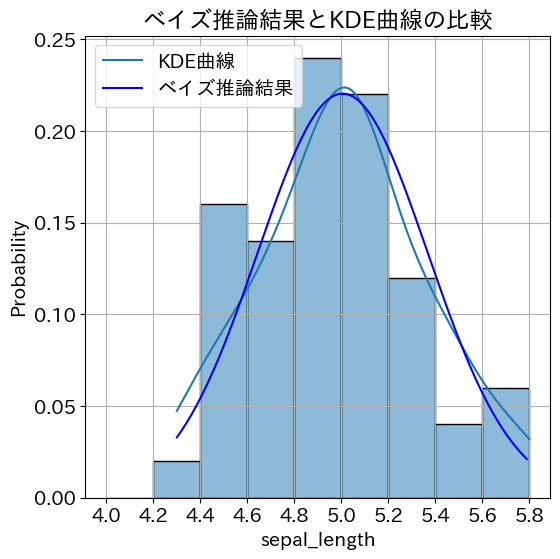

In [17]:
delta = 0.2
# ヒストグラムのビン幅を delta として設定
# ------------------------------------------------------------
# ヒストグラムは「各ビン区間内に落ちる確率（あるいは頻度）」を描画する。
# ビン幅を delta に固定すると、
#   ・ビン幅が広いほど滑らかになるが情報が粗くなる
#   ・ビン幅が狭いほど細かくなるがノイズが増える
# といったトレードオフがある。
# ここでは 0.2 という幅で、sepal_length (4〜6 付近) の分布を
# 過不足なく表現できるようにしている。
bins = np.arange(4.0, 6.0, delta)

# 図と Axes を用意
fig, ax = plt.subplots()

# setosa の sepal_length のヒストグラム＋KDE を描画
# ------------------------------------------------------------
# sns.histplot(..., stat='probability') としている点が重要で、
# ヒストグラムの「高さ」が
#   ・単なる度数（count）ではなく
#   ・確率（各ビンに入る確率質量）
# になるように正規化されている。
#
# そのため、
#   ・各ビンの高さ ≒ P(そのビンに入る)
#   ・全ビンの高さの和 ≒ 1
# という関係が成り立ち、後で重ねるベイズ推論結果（正規分布）の
# PDF と比較しやすくなる。
sns.histplot(
    df1,
    ax=ax,
    x="sepal_length",
    bins=bins,
    kde=True,  # KDE（カーネル密度推定）による滑らかな近似曲線も表示
    stat="probability",  # ヒストグラムの縦軸を「確率」に正規化
)

# histplot が内部で描画した KDE 曲線（折れ線）の Line2D を取り出し，
# 凡例ラベルを設定する。
# KDE は非パラメトリックな手法であり，
# 「データそのものから滑らかな密度関数を推定したもの」として，
# ベイズ推論による parametric モデル（正規分布）と対比できる。
ax.get_lines()[0].set_label("KDE曲線")

# x 軸の目盛り位置をビン境界に揃えることで，
# 「どのビンがどの区間を表しているか」が視覚的に分かりやすくなる。
ax.set_xticks(bins)

# ベイズ推論で得た正規分布モデルの PDF を重ね描き
# ------------------------------------------------------------
# y_list は「連続密度 f(x)」である一方，
# ヒストグラムの縦軸は「各ビン区間の確率質量 P(bin)」になっている。
#
# 連続密度 f(x) と離散ビン確率 P(bin) を同じスケールで比較するには，
# おおよそ
#   P(bin) ≈ f(x) * (ビン幅)
# という関係（区分求積・台形近似）を使う。
#
# したがって，ここで y_list * delta としているのは，
# 「連続密度 f(x) を，幅 delta のビンに対応する確率質量に変換している」
# という意味を持つ。
# こうすることで，
#   ・ヒストグラム（確率質量の棒）
#   ・KDE（データ駆動の密度推定）
#   ・ベイズ推論で得た正規分布モデル（parametric な密度）
# を同じ縦軸スケールで比較できる。
ax.plot(
    x_list, y_list * delta, c="b", label="ベイズ推論結果"  # PDF → ビン確率質量への変換
)

# グラフタイトル：ベイズ推論で得た parametric モデルと，
# KDE による non-parametric な推定を比較していることを明示。
ax.set_title("ベイズ推論結果とKDE曲線の比較")

# 凡例表示
plt.legend()

In [18]:
# 観測データ X から先頭 5 件だけを取り出す
# ------------------------------------------------------------
# 元の X は setosa の sepal_length 全体（おそらく 50 サンプル前後）を
# 含んでいると考えられる。
#
# ここで X_less = X[:5] としているのは、
#   ・サンプルサイズ n を意図的に 5 に減らしたとき、
#   ・平均や分散などの推定がどれだけ不安定になるか
# を確認するための操作として解釈できる。
#
# 理論的には、標本サイズ n が小さいほど
#   ・標本平均の分散 Var( \bar{X} ) = σ^2 / n が大きくなり
#   ・標本分散も大きくぶれやすくなる
# ため、推定の不確実性が増す。
# ベイズ推論でも、データ量が少ない場合には事前分布の影響が強く残るため、
# このような「小標本」を取り出しておくと、事前の影響を観察しやすい。
X_less = X[:5]

# 小標本の値をそのまま確認
# ------------------------------------------------------------
# 実際の数値を目視することで、
#   ・明らかな外れ値や入力ミスがないか
#   ・値のスケール感が元の全データと大きく変わっていないか
# をざっくりとチェックできる。
# 特に n=5 程度の小標本では、数値 1 つ 1 つが統計量に与える影響が大きいため、
# 生データの確認は重要である。
print(X_less)

# 小標本に対する記述統計量の確認
# ------------------------------------------------------------
# pd.Series(X_less).describe() によって、
#   ・count（サンプル数）
#   ・mean（標本平均）
#   ・std（標本標準偏差）
#   ・min, max
#   ・四分位点（25%, 50%, 75%）
# などが計算される。
#
# 理論的には、これらは元の母集団分布の
#   ・母平均 μ
#   ・母標準偏差 σ
#   ・分位点
# の推定量になっているが、n=5 と非常に小さいため、
# 「全データ（n≈50）から計算した describe() の値」と比較すると
# かなりぶれるはずである。
#
# この差異を観察することで、
#   ・サンプルサイズが推定の安定性に与える影響
#   ・ベイズ推論でデータ量が増えるにつれて事後分布がどのように収束するか
# といった理論（大数の法則・中心極限定理）の直感を掴みやすくなる。
print(pd.Series(X_less).describe())

[5.100 4.900 4.700 4.600 5.000]
count   5.000
mean    4.860
std     0.207
min     4.600
25%     4.700
50%     4.900
75%     5.000
max     5.100
dtype: float64


In [19]:
model2 = pm.Model()

with model2:
    mu = pm.Normal("mu", mu=0.0, sigma=10.0)
    sigma = pm.HalfNormal("sigma", sigma=10.0)
    X_obs = pm.Normal("X_obs", mu=mu, sigma=sigma, observed=X_less)

    # サンプリング
    idata2 = pm.sample(random_seed=42)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


array([<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'sigma'}>],
      dtype=object)

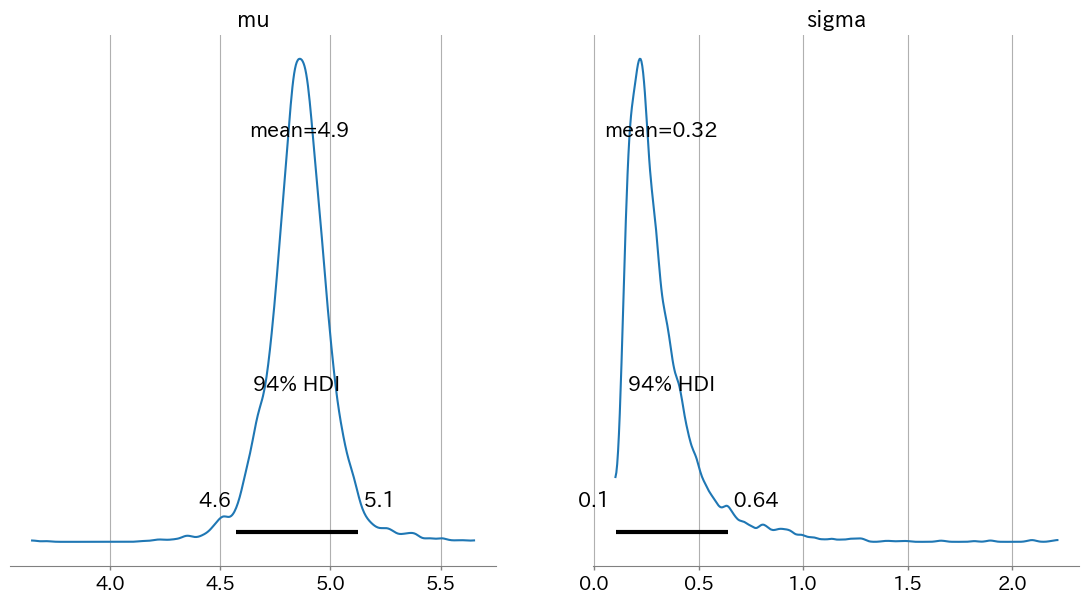

In [20]:
az.plot_posterior(idata2)

In [21]:
summary2 = az.summary(idata2)
display(summary2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,4.860,0.150,4.572,5.124,0.005,0.008,1202.000,874.000,1.000
sigma,0.320,0.195,0.104,0.640,0.007,0.013,1024.000,1050.000,1.000


In [22]:
model3 = pm.Model()

with model3:
    # --- パラメータ μ の事前分布 ---
    # mu: ガウス分布の「平均」に相当するパラメータ。
    # ここでは
    #   μ ~ N(0, 10^2)
    # という非常に広い正規分布を事前として与えている。
    # 分布の中心 0 からかなり離れた値も十分あり得るとみなす
    # 「ほぼ非情報的な事前」であり、事後分布は主にデータ X によって
    # 形が決まることを意図している。
    mu = pm.Normal("mu", mu=0.0, sigma=10.0)

    # --- パラメータ τ の事前分布（精度パラメータ） ---
    # tau: ガウス分布の「精度」に相当するパラメータで、
    #   τ = 1 / σ^2
    # の関係にある（σ は標準偏差）。
    #
    # ここでは
    #   τ ~ HalfNormal(10)
    # という半正規分布を事前として使っている。
    # HalfNormal は 0 以上の値のみを取る連続分布なので、
    # 精度 τ が負にならないという条件を自然に満たす。
    # 広いスケール 10 を設定しているため、非常に小さい τ（大きい σ）から
    # ある程度大きい τ（小さい σ）まで幅広く許容する、非情報的な事前になっている。
    tau = pm.HalfNormal("tau", sigma=10.0)

    # --- 観測モデル（尤度）：正規分布 N(μ, τ) ---
    # X_obs: 観測データ X に対する生成モデル（尤度）を定義している。
    #
    # PyMC の pm.Normal では
    #   ・sigma: 標準偏差 σ
    #   ・tau  : 精度 τ = 1 / σ^2
    # のどちらか一方でスケールを指定できる。
    #
    # ここでは tau 引数を使っているので、
    #   X_i | μ, τ ~ N(μ, 1/τ)
    # というモデルを表すことになる。
    # 「平均 μ と精度 τ を同時に推論するガウスモデル」として
    # 多くのベイズ入門で出てくる基本形である。
    X_obs = pm.Normal("X_obs", mu=mu, tau=tau, observed=X)

    # --- τ から σ を導出する決定論的パラメータ ---
    # sigma: τ から計算される標準偏差 σ を決定論的に定義している。
    # 定義式は
    #   σ = 1 / sqrt(τ)
    # であり、精度と標準偏差の関係
    #   τ = 1 / σ^2
    # をただ変形したもの。
    #
    # pm.Deterministic を使うことで、サンプリングされた各 τ の値ごとに
    # 対応する σ が毎回計算され、トレースや事後要約に
    # 「sigma」という名前の変数として保存される。
    # これにより、
    #   ・精度 τ の事後分布
    #   ・標準偏差 σ の事後分布
    # の両方を後から簡単に可視化・解釈できるようになる。
    sigma = pm.Deterministic("sigma", 1 / pm.math.sqrt(tau))

    # --- 事後サンプリング ---
    # pm.sample は、定義したベイズモデル
    #
    #   μ ~ N(0, 10^2)
    #   τ ~ HalfNormal(10)
    #   X | μ, τ ~ N(μ, 1/τ)
    #
    # に対する事後分布 p(μ, τ | X)（および変換変数 σ）の
    # 近似サンプルを MCMC で生成する。
    #
    # random_seed=42 によって乱数系列を固定しており、
    # 同じ環境・同じバージョンの PyMC であれば
    # 同じサンプル列を再現できるようになっている。
    idata3 = pm.sample(random_seed=42)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


array([<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'tau'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

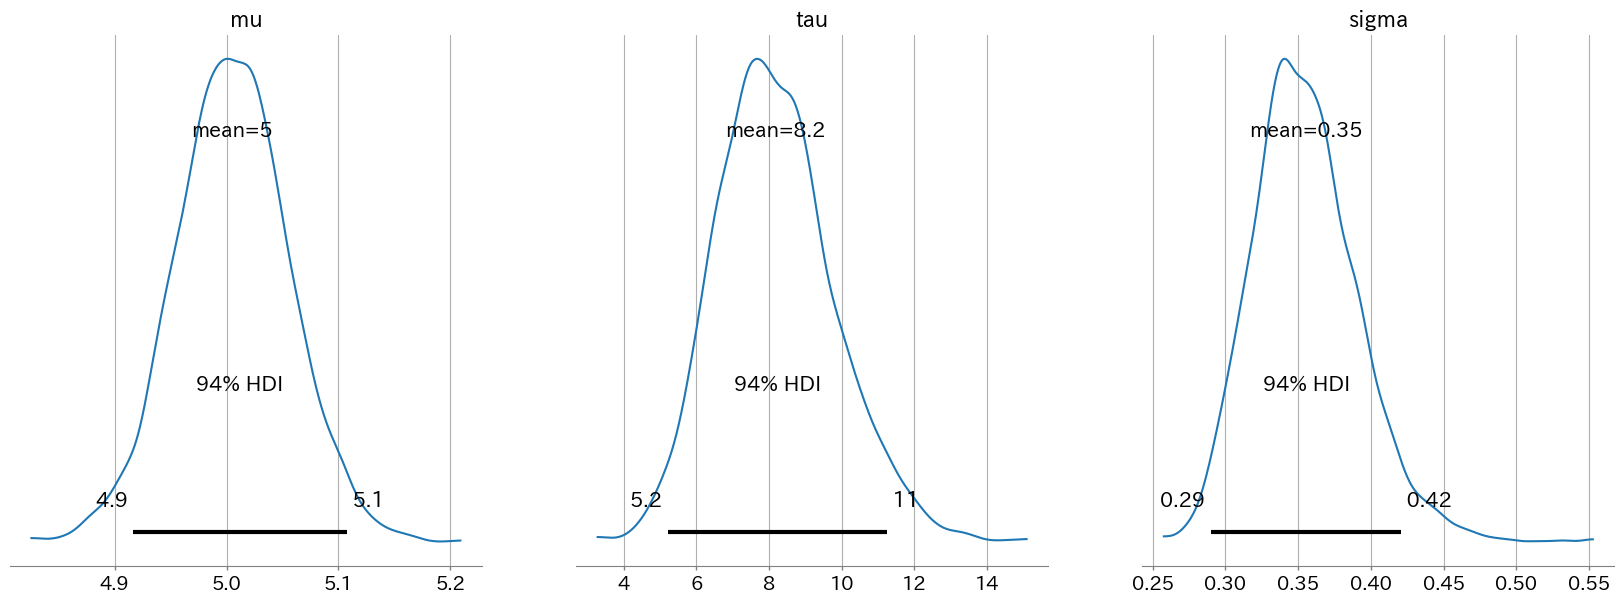

In [23]:
az.plot_posterior(idata3)